# How to create a custom checkpointer using MongoDB

When creating LangGraph agents, you can also set them up so that they persist their state. This allows you to do things like interact with an agent multiple times and have it remember previous interactions.

This example shows how to use `MongoDB` as the backend for persisting checkpoint state.

NOTE: this is just an example implementation. You can implement your own checkpointer using a different database or modify this one as long as it conforms to the `BaseCheckpointSaver` interface.

## Checkpointer implementation

In [ ]:
%%capture --no-stderr
%pip install -U psycopg psycopg-pool langgraph pymongo

In [2]:
import pickle
from contextlib import AbstractContextManager
from types import TracebackType
from typing import Any, Dict, Iterator, Optional

from langchain_core.runnables import RunnableConfig
from typing_extensions import Self

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    SerializerProtocol,
)
from langgraph.serde.jsonplus import JsonPlusSerializer
from pymongo import MongoClient


class JsonPlusSerializerCompat(JsonPlusSerializer):
    """A serializer that supports loading pickled checkpoints for backwards compatibility.

    This serializer extends the JsonPlusSerializer and adds support for loading pickled
    checkpoints. If the input data starts with b"\x80" and ends with b".", it is treated
    as a pickled checkpoint and loaded using pickle.loads(). Otherwise, the default
    JsonPlusSerializer behavior is used.

    Examples:
        >>> import pickle
        >>> from langgraph.checkpoint.sqlite import JsonPlusSerializerCompat
        >>>
        >>> serializer = JsonPlusSerializerCompat()
        >>> pickled_data = pickle.dumps({"key": "value"})
        >>> loaded_data = serializer.loads(pickled_data)
        >>> print(loaded_data)  # Output: {"key": "value"}
        >>>
        >>> json_data = '{"key": "value"}'.encode("utf-8")
        >>> loaded_data = serializer.loads(json_data)
        >>> print(loaded_data)  # Output: {"key": "value"}
    """

    def loads(self, data: bytes) -> Any:
        if data.startswith(b"\x80") and data.endswith(b"."):
            return pickle.loads(data)
        return super().loads(data)

class MongoDBSaver(AbstractContextManager, BaseCheckpointSaver):
    """A checkpoint saver that stores checkpoints in a MongoDB database.

    Args:
        client (pymongo.MongoClient): The MongoDB client.
        db_name (str): The name of the database to use.
        collection_name (str): The name of the collection to use.
        serde (Optional[SerializerProtocol]): The serializer to use for serializing and deserializing checkpoints. Defaults to JsonPlusSerializerCompat.

    Examples:

        >>> from pymongo import MongoClient
        >>> from langgraph.checkpoint.mongodb import MongoDBSaver
        >>> from langgraph.graph import StateGraph
        >>>
        >>> builder = StateGraph(int)
        >>> builder.add_node("add_one", lambda x: x + 1)
        >>> builder.set_entry_point("add_one")
        >>> builder.set_finish_point("add_one")
        >>> client = MongoClient("mongodb://localhost:27017/")
        >>> memory = MongoDBSaver(client, "checkpoints", "checkpoints")
        >>> graph = builder.compile(checkpointer=memory)
        >>> config = {"configurable": {"thread_id": "1"}}
        >>> graph.get_state(config)
        >>> result = graph.invoke(3, config)
        >>> graph.get_state(config)
        StateSnapshot(values=4, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '2024-05-04T06:32:42.235444+00:00'}}, parent_config=None)
    """

    serde = JsonPlusSerializerCompat()

    client: MongoClient
    db_name: str
    collection_name: str

    def __init__(
        self,
        client: MongoClient,
        db_name: str,
        collection_name: str,
        *,
        serde: Optional[SerializerProtocol] = None,
    ) -> None:
        super().__init__(serde=serde)
        self.client = client
        self.db_name = db_name
        self.collection_name = collection_name
        self.collection = client[db_name][collection_name]

    def __enter__(self) -> Self:
        return self

    def __exit__(
        self,
        __exc_type: Optional[type[BaseException]],
        __exc_value: Optional[BaseException],
        __traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        return True

    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        """Get a checkpoint tuple from the database.

        This method retrieves a checkpoint tuple from the MongoDB database based on the
        provided config. If the config contains a "thread_ts" key, the checkpoint with
        the matching thread ID and timestamp is retrieved. Otherwise, the latest checkpoint
        for the given thread ID is retrieved.

        Args:
            config (RunnableConfig): The config to use for retrieving the checkpoint.

        Returns:
            Optional[CheckpointTuple]: The retrieved checkpoint tuple, or None if no matching checkpoint was found.
        """
        if config["configurable"].get("thread_ts"):
            query = {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": config["configurable"]["thread_ts"],
            }
        else:
            query = {"thread_id": config["configurable"]["thread_id"]}
        result = self.collection.find(query).sort("thread_ts", -1).limit(1)
        for doc in result:
            return CheckpointTuple(
                config,
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    def list(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> Iterator[CheckpointTuple]:
        """List checkpoints from the database.

        This method retrieves a list of checkpoint tuples from the MongoDB database based
        on the provided config. The checkpoints are ordered by timestamp in descending order.

        Args:
            config (RunnableConfig): The config to use for listing the checkpoints.
            before (Optional[RunnableConfig]): If provided, only checkpoints before the specified timestamp are returned. Defaults to None.
            limit (Optional[int]): The maximum number of checkpoints to return. Defaults to None.

        Yields:
            Iterator[CheckpointTuple]: An iterator of checkpoint tuples.
        """
        query = {}
        if config is not None:
            query["thread_id"] = config["configurable"]["thread_id"]
        if filter:
            for key, value in filter.items():
                query[f"metadata.{key}"] = value
        if before is not None:
            query["thread_ts"] = {"$lt": before["configurable"]["thread_ts"]}
        result = self.collection.find(query).sort("thread_ts", -1).limit(limit)
        for doc in result:
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "thread_ts": doc["thread_ts"],
                    }
                },
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    def put(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
    ) -> RunnableConfig:
        """Save a checkpoint to the database.

        This method saves a checkpoint to the MongoDB database. The checkpoint is associated
        with the provided config and its parent config (if any).

        Args:
            config (RunnableConfig): The config to associate with the checkpoint.
            checkpoint (Checkpoint): The checkpoint to save.
            metadata (Optional[dict[str, Any]]): Additional metadata to save with the checkpoint. Defaults to None.

        Returns:
            RunnableConfig: The updated config containing the saved checkpoint's timestamp.
        """
        doc = {
            "thread_id": config["configurable"]["thread_id"],
            "thread_ts": checkpoint["id"],
            "checkpoint": self.serde.dumps(checkpoint),
            "metadata": self.serde.dumps(metadata),
        }
        if config["configurable"].get("thread_ts"):
            doc["parent_ts"] = config["configurable"]["thread_ts"]
        self.collection.insert_one(doc)
        return {
            "configurable": {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": checkpoint["id"],
            }
        }

## MongoDB connection

In [3]:
MONGO_URI = "mongodb://localhost:27017/"

## Basic example using graph

In [4]:
from langgraph.graph import StateGraph

checkpointer = MongoDBSaver(MongoClient(MONGO_URI), "checkpoints_db", "checkpoints_collection")
builder = StateGraph(int)
builder.add_node("add_one", lambda x: x + 1)
builder.set_entry_point("add_one")
builder.set_finish_point("add_one")
graph = builder.compile(checkpointer=checkpointer)
config = {"configurable": {"thread_id": "123"}}
graph.get_state(config)
result = graph.invoke(3,config)
graph.get_state(config)

StateSnapshot(values=4, next=(), config={'configurable': {'thread_id': '123'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'add_one': 4}}, created_at='2024-07-09T05:59:02.742950+00:00', parent_config={'configurable': {'thread_id': '123', 'thread_ts': '1ef3db85-7c1c-69d5-8000-fa9878e4f2b9'}})

In [5]:
result

4

## Setup environment

In [6]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Setup model and tools for the graph

In [ ]:
%pip install langchain_openai

In [8]:
from typing import Literal
from langchain_core.runnables import ConfigurableField
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]
model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [9]:
graph = create_react_agent(model, tools=tools, checkpointer=checkpointer)
config = {"configurable": {"thread_id": "1"}}
res = graph.invoke({"messages": [("human", "what's the weather in sf")]}, config)

In [10]:
res

{'messages': [HumanMessage(content="what's the weather in sf", id='6f08f821-2b40-416b-a0ea-c16a3d79be1f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7zZnmZp7FwpLrTgH0iIvQOfb', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-043bb732-de11-4651-aeda-518edf3f7f1e-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_7zZnmZp7FwpLrTgH0iIvQOfb'}], usage_metadata={'input_tokens': 58, 'output_tokens': 14, 'total_tokens': 72}),
  ToolMessage(content="It's always sunny in sf", name='get_weather', id='21c3d817-21dc-4a46-994a-4377928bdba7', tool_call_id='call_7zZnmZp7FwpLrTgH0iIvQOfb'),
  AIMessage(content='The weather in San Francisco is always sunny!', response_metadata={'token_usage'

### Checkpoints saved in MongoDB

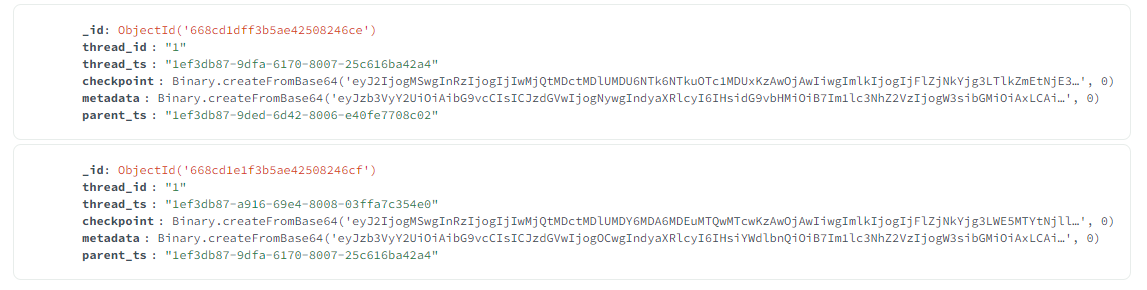